In [1]:
#Importing libararies
%matplotlib inline
import os
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (12, 8)
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score , confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import SparseRandomProjection
from sklearn.feature_selection import RFECV
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Change the directory name
os.chdir('C:/Users/ssahi/Documents/ML_Course/Assignment_1')

In [3]:
#Reading the data
df = pd.read_csv("sgemm_product.csv")

#Taking the average of runs for target variable
df["avg_run"] = df.iloc[:,14:].mean(axis = 1)

#Taking log of the Average run times
df["log_avg_run"] = np.log(df.avg_run) 

#Dropping the four Run columns
df.drop(['Run1 (ms)', 'Run2 (ms)','Run3 (ms)', 'Run4 (ms)'], axis = 1, inplace = True)

#Dropping the Average run column
df.drop(['avg_run'], axis = 1, inplace = True)

#Creating target classes
#threshold = median = 4.245490733029061

thresh = df.log_avg_run.median()
df["Tgt_Class"] = df.log_avg_run.apply(lambda x : 0 if x <= thresh else 1)
df.drop(['log_avg_run'], axis = 1, inplace = True)

In [4]:
# Finding the count of the existing class labels
values = df["Tgt_Class"].value_counts()
target = []
target_count = []
for index, value in values.items():
    target.append(index)
    target_count.append(value)
    
print(target)
print(target_count)

[0, 1]
[120801, 120799]


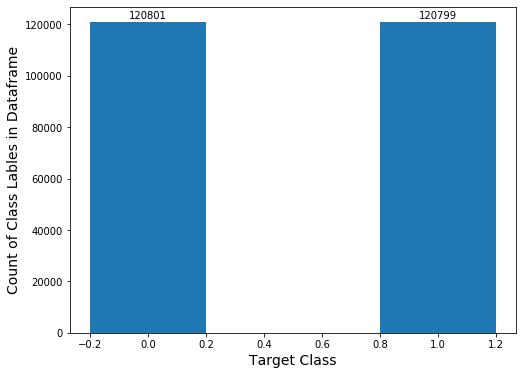

In [6]:
# Plotting the count of the existing class labels
plt.rcParams['figure.figsize'] = (8, 6)
plt.bar(target, target_count, width=0.4, align='center')
plt.xlabel('Target Class', fontsize=14)
plt.ylabel('Count of Class Lables in Dataframe', fontsize=14)
for i, v in enumerate(target_count):
    plt.text(i,v+2500,str(v), horizontalalignment='center', verticalalignment='center')
plt.show()

In [5]:
#Divide the data into independent features X and Clasification lables Y
X = df.drop('Tgt_Class', axis=1)
y = df['Tgt_Class']

scaler = StandardScaler().fit(X)
X_sc = scaler.transform(X)
X_sc = pd.DataFrame(X_sc)

In [6]:
# Divide the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 11)

#Scaling the independent features
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### K-means using the same clusters as the number of class labels

In [56]:
kmeans_Model = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=500, precompute_distances=True, random_state=0)
kmeans_Model.fit(X_sc)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances=True,
       random_state=0, tol=0.0001, verbose=0)

In [57]:
predict_clusters_kmeans_original = kmeans_Model.predict(X_sc)
(unique, counts) = np.unique(predict_clusters_kmeans_original, return_counts=True)

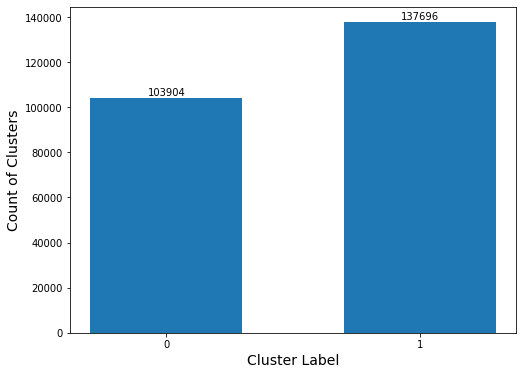

In [59]:
# Plotting the cluster counts
plt.rcParams['figure.figsize'] = (8, 6)
plt.bar(unique, counts, width=0.6, align='center')
plt.xlabel('Cluster Label', fontsize=14)
plt.ylabel('Count of Clusters', fontsize=14)
plt.xticks(unique)
for i, v in enumerate(counts):
    plt.text(i,v+2500,str(v), horizontalalignment='center', verticalalignment='center')
plt.show()

In [60]:
print("adjusted_rand_score:", metrics.adjusted_rand_score(y, predict_clusters_kmeans_original))
print("adjusted_mutual_info_score:", metrics.adjusted_mutual_info_score(y, predict_clusters_kmeans_original))
print("homogeneity_score:", metrics.homogeneity_score(y, predict_clusters_kmeans_original))
print("completeness_score:", metrics.completeness_score(y, predict_clusters_kmeans_original))

adjusted_rand_score: 0.16086532036462783
adjusted_mutual_info_score: 0.12301716117544505
homogeneity_score: 0.12214893824258334
completeness_score: 0.12390316505893448


### Changing number of clusters in K-means

In [50]:
sse = []
ars = []
amis = []
hs = []
cs = []
cluster_size = np.arange(2,10,1)

for i in cluster_size:
    kmeans_Model = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=500
                          , precompute_distances=True, random_state=0)
    kmeans_Model.fit(X_sc)
    sse.append(kmeans_Model.inertia_)
    
    predict_clusters = kmeans_Model.predict(X_sc)
    ars.append(metrics.adjusted_rand_score(y, predict_clusters))
    amis.append(metrics.adjusted_mutual_info_score(y, predict_clusters))
    hs.append(metrics.homogeneity_score(y, predict_clusters))
    cs.append(metrics.completeness_score(y, predict_clusters))

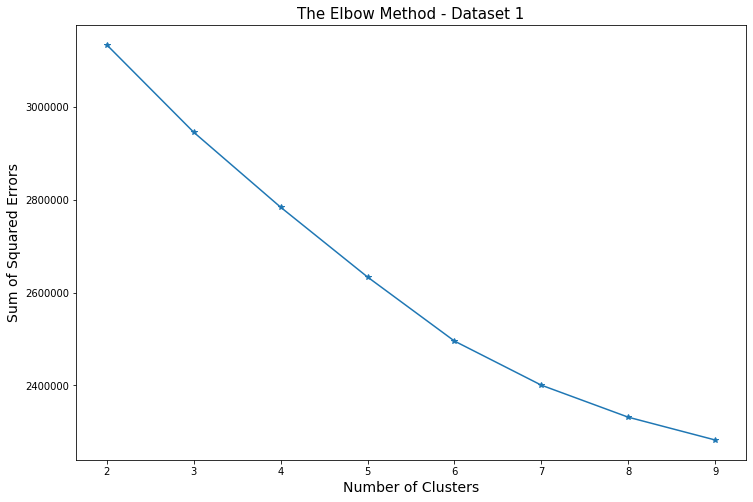

In [51]:
plt.plot(cluster_size, sse, marker='*')
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('Sum of Squared Errors', fontsize=14)
plt.xticks(cluster_size)
plt.title('The Elbow Method - Dataset 1', fontsize=15)
plt.show()

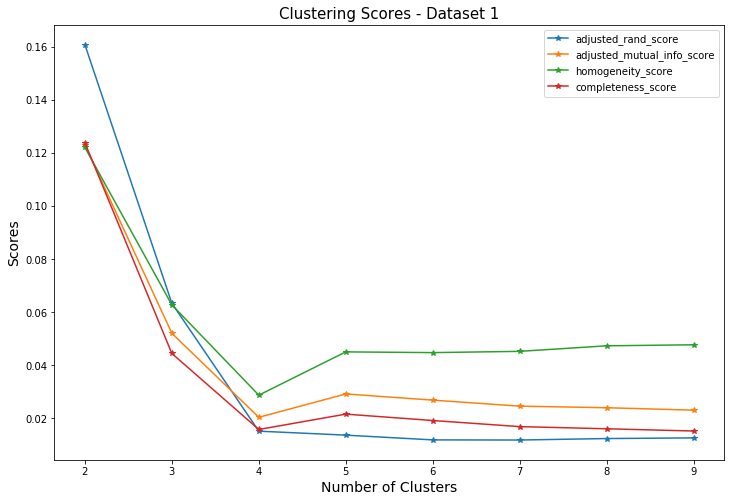

In [52]:
plt.plot(cluster_size, ars, marker='*', label='adjusted_rand_score')
plt.plot(cluster_size, amis, marker='*', label='adjusted_mutual_info_score')
plt.plot(cluster_size, hs, marker='*', label='homogeneity_score')
plt.plot(cluster_size, cs, marker='*', label='completeness_score')
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.xticks(cluster_size)
plt.legend()
plt.title('Clustering Scores - Dataset 1', fontsize=15)
plt.show()

In [98]:
# best model
kmeans_Model = KMeans(n_clusters=7, init='k-means++', n_init=10, max_iter=500, precompute_distances=True, random_state=0)
kmeans_Model.fit(X_sc)
predict_kmeans = kmeans_Model.predict(X_sc)
(unique, counts) = np.unique(predict_kmeans, return_counts=True)

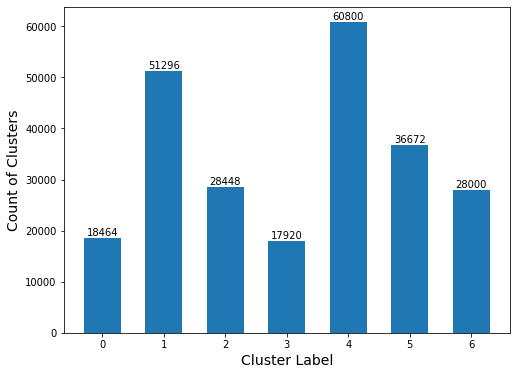

In [99]:
# Plotting the cluster counts
plt.rcParams['figure.figsize'] = (8, 6)
plt.bar(unique, counts, width=0.6, align='center')
plt.xlabel('Cluster Label', fontsize=14)
plt.ylabel('Count of Clusters', fontsize=14)
plt.xticks(unique)
for i, v in enumerate(counts):
    plt.text(i,v+1100,str(v), horizontalalignment='center', verticalalignment='center')
plt.show()

In [63]:
print("adjusted_rand_score:", metrics.adjusted_rand_score(y, predict_kmeans))
print("adjusted_mutual_info_score:", metrics.adjusted_mutual_info_score(y, predict_kmeans))
print("homogeneity_score:", metrics.homogeneity_score(y, predict_kmeans))
print("completeness_score:", metrics.completeness_score(y, predict_kmeans))

adjusted_rand_score: 0.011883196400139373
adjusted_mutual_info_score: 0.02465016172473405
homogeneity_score: 0.04530044325799807
completeness_score: 0.01694075794370758


### Impelementing PCA

In [17]:
pca = PCA(n_components= None)
pca.fit_transform(X_sc)
var = pca.explained_variance_ratio_

In [21]:
for i in range(1,15):
    print("Percentage Variance explained by",i, "components :", "{:.3f}".format(sum(var[0:i]*100)), "%")

Percentage Variance explained by 1 components : 10.185 %
Percentage Variance explained by 2 components : 20.030 %
Percentage Variance explained by 3 components : 29.578 %
Percentage Variance explained by 4 components : 38.996 %
Percentage Variance explained by 5 components : 46.693 %
Percentage Variance explained by 6 components : 53.836 %
Percentage Variance explained by 7 components : 60.979 %
Percentage Variance explained by 8 components : 68.122 %
Percentage Variance explained by 9 components : 75.265 %
Percentage Variance explained by 10 components : 82.408 %
Percentage Variance explained by 11 components : 89.038 %
Percentage Variance explained by 12 components : 92.836 %
Percentage Variance explained by 13 components : 96.468 %
Percentage Variance explained by 14 components : 100.000 %


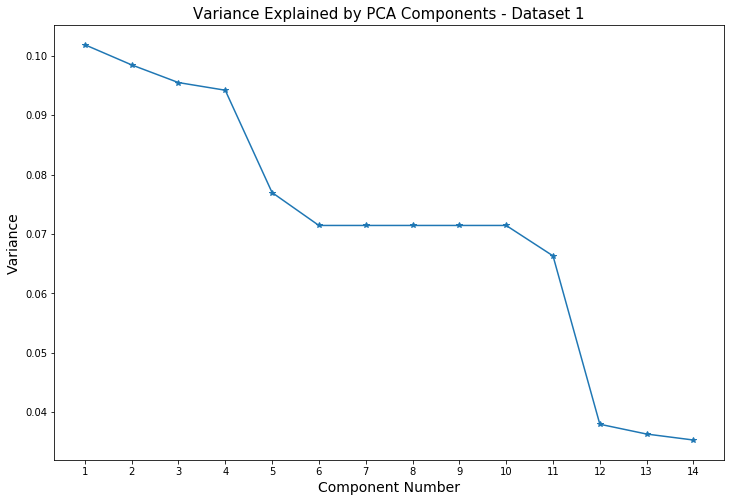

In [24]:
x=np.arange(1,len(var)+1,1)
plt.plot(x, var, marker='*')
plt.title("Variance Explained by PCA Components - Dataset 1", fontsize=15)
plt.xlabel("Component Number", fontsize=14)
plt.ylabel("Variance", fontsize=14)
plt.xticks(x)
plt.show()

In [7]:
pca_final = PCA(n_components = 10)
X_PCA = pca_final.fit_transform(X_sc)

### Implementing ICA

In [8]:
ica = FastICA(n_components=10)
X_ICA = ica.fit_transform(X_sc)

### Implementing Random Projections

In [9]:
srp = SparseRandomProjection(random_state=0, n_components=10)
X_RP = srp.fit_transform(X_sc)

### Implementing Feature selection

In [28]:
decTree = DecisionTreeClassifier(criterion = 'gini', max_depth=15)
rfecv = RFECV(estimator=decTree, step=1, cv=5, scoring='accuracy')
rfecv.fit(X_sc, y)

RFECV(cv=5,
      estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                       criterion='gini', max_depth=15,
                                       max_features=None, max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       presort='deprecated', random_state=None,
                                       splitter='best'),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

In [29]:
print("Optimal number of features :", rfecv.n_features_)
print(rfecv.ranking_)

Optimal number of features : 8
[1 1 3 1 1 4 5 7 1 2 1 6 1 1]


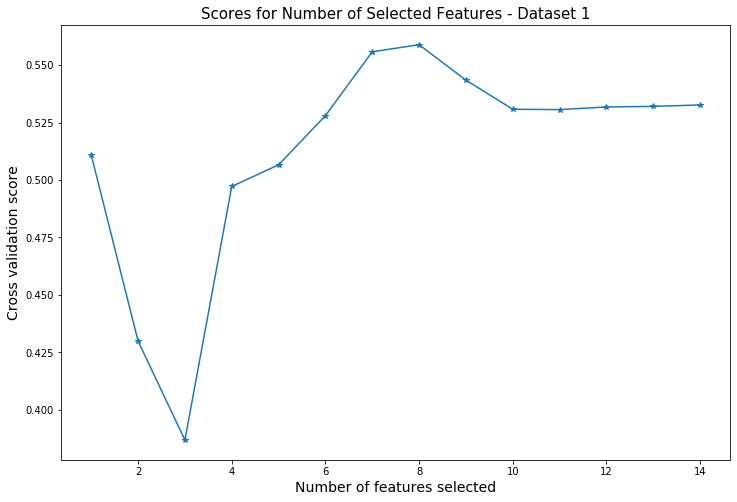

In [30]:
plt.figure()
plt.plot(range(1, len(rfecv.grid_scores_)+1), rfecv.grid_scores_, marker='*')
plt.xlabel("Number of features selected", fontsize=14)
plt.ylabel("Cross validation score", fontsize=14)
plt.title("Scores for Number of Selected Features - Dataset 1", fontsize=15)
plt.show()

In [10]:
X_FS = X_sc.iloc[:,[0,1,3,4,8,10,12,13]]

### K-means after Dimensionality Reduction

#### With PCA

In [67]:
sse = []
ars = []
amis = []
hs = []
cs = []
cluster_size = np.arange(2,10,1)

for i in cluster_size:
    kmeans_Model = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=500
                          , precompute_distances=True, random_state=0)
    kmeans_Model.fit(X_PCA)
    sse.append(kmeans_Model.inertia_)
    
    predict_clusters = kmeans_Model.predict(X_PCA)
    ars.append(metrics.adjusted_rand_score(y, predict_clusters))
    amis.append(metrics.adjusted_mutual_info_score(y, predict_clusters))
    hs.append(metrics.homogeneity_score(y, predict_clusters))
    cs.append(metrics.completeness_score(y, predict_clusters))

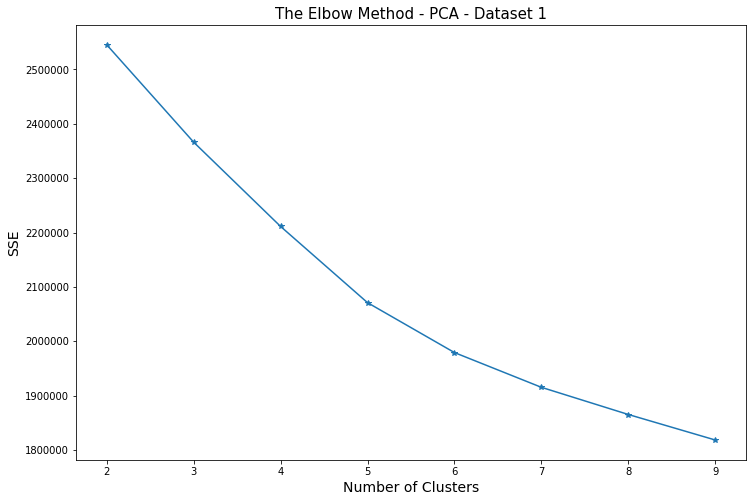

In [70]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.plot(cluster_size, sse, marker='*')
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('SSE', fontsize=14)
plt.xticks(cluster_size)
plt.title('The Elbow Method - PCA - Dataset 1', fontsize=15)
plt.show()

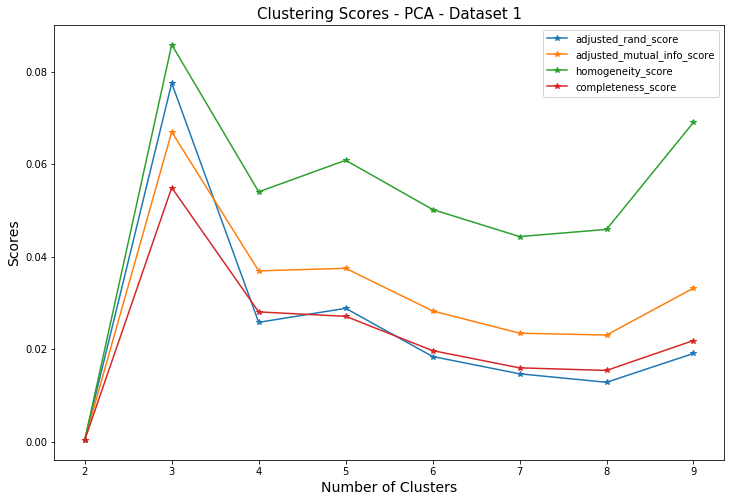

In [71]:
plt.plot(cluster_size, ars, marker='*', label='adjusted_rand_score')
plt.plot(cluster_size, amis, marker='*', label='adjusted_mutual_info_score')
plt.plot(cluster_size, hs, marker='*', label='homogeneity_score')
plt.plot(cluster_size, cs, marker='*', label='completeness_score')
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.xticks(cluster_size)
plt.legend()
plt.title('Clustering Scores - PCA - Dataset 1', fontsize=15)
plt.show()

[0 1 2 3 4 5 6]
[38302 24928 38584 34960 34968 44362 25496]


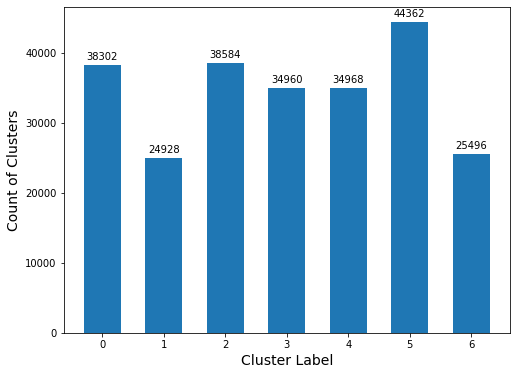

In [75]:
# With PCA and 7 clusters - best model
kmeans_Model = KMeans(n_clusters=7, init='k-means++', n_init=10, max_iter=500
                          , precompute_distances=True, random_state=0)
kmeans_Model.fit(X_PCA)
predict_clusters = kmeans_Model.predict(X_PCA)
(unique, counts) = np.unique(predict_clusters, return_counts=True)
print(unique)
print(counts)

# Plotting the cluster counts
plt.rcParams['figure.figsize'] = (8, 6)
plt.bar(unique, counts, width=0.6, align='center')
plt.xlabel('Cluster Label', fontsize=14)
plt.ylabel('Count of Clusters', fontsize=14)
plt.xticks(unique)
for i, v in enumerate(counts):
    plt.text(i,v+1200,str(v), horizontalalignment='center', verticalalignment='center')
plt.show()

In [76]:
# Scores with class labels
print("adjusted_rand_score:", metrics.adjusted_rand_score(y, predict_clusters))
print("adjusted_mutual_info_score:", metrics.adjusted_mutual_info_score(y, predict_clusters))
print("homogeneity_score:", metrics.homogeneity_score(y, predict_clusters))
print("completeness_score:", metrics.completeness_score(y, predict_clusters))

adjusted_rand_score: 0.014655239813983024
adjusted_mutual_info_score: 0.02343947442632052
homogeneity_score: 0.04432397629474756
completeness_score: 0.01594100189035934


In [77]:
# Scores with clusters of K-means without dimentionality reduction
print("adjusted_rand_score:", metrics.adjusted_rand_score(predict_kmeans, predict_clusters))
print("adjusted_mutual_info_score:", metrics.adjusted_mutual_info_score(predict_kmeans, predict_clusters))
print("homogeneity_score:", metrics.homogeneity_score(predict_kmeans, predict_clusters))
print("completeness_score:", metrics.completeness_score(predict_kmeans, predict_clusters))

adjusted_rand_score: 0.46731728531220484
adjusted_mutual_info_score: 0.5857781471825431
homogeneity_score: 0.597454358987462
completeness_score: 0.5745809827864812


#### With ICA

In [78]:
sse = []
ars = []
amis = []
hs = []
cs = []
cluster_size = np.arange(2,10,1)

for i in cluster_size:
    kmeans_Model = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=500
                          , precompute_distances=True, random_state=0)
    kmeans_Model.fit(X_ICA)
    sse.append(kmeans_Model.inertia_)
    
    predict_clusters = kmeans_Model.predict(X_ICA)
    ars.append(metrics.adjusted_rand_score(y, predict_clusters))
    amis.append(metrics.adjusted_mutual_info_score(y, predict_clusters))
    hs.append(metrics.homogeneity_score(y, predict_clusters))
    cs.append(metrics.completeness_score(y, predict_clusters))

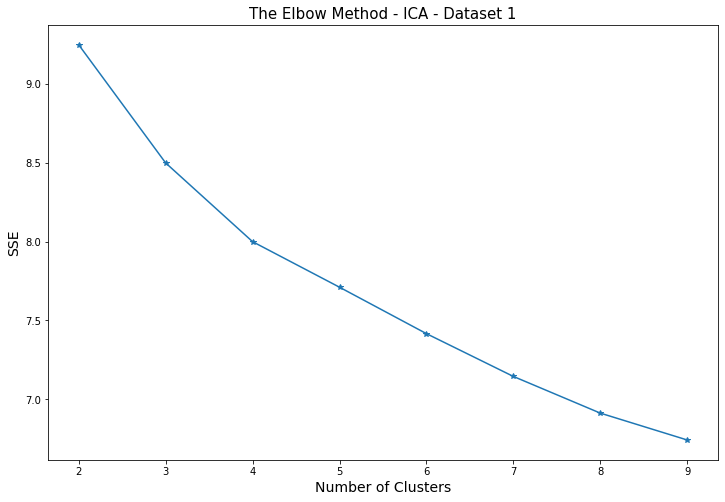

In [79]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.plot(cluster_size, sse, marker='*')
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('SSE', fontsize=14)
plt.xticks(cluster_size)
plt.title('The Elbow Method - ICA - Dataset 1', fontsize=15)
plt.show()

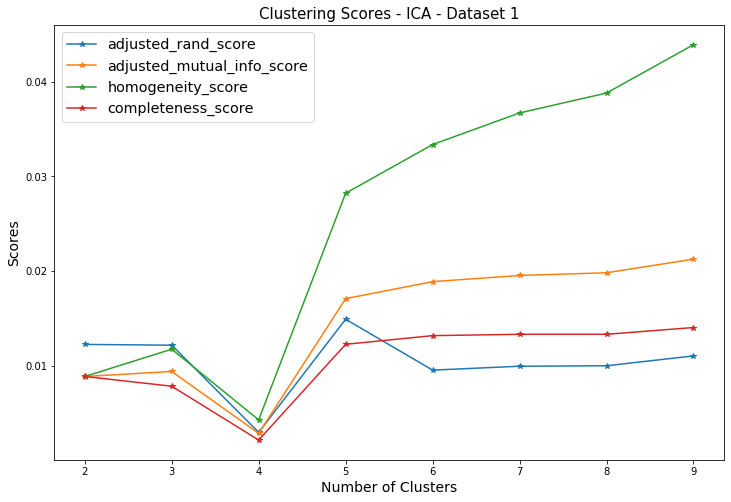

In [80]:
plt.plot(cluster_size, ars, marker='*', label='adjusted_rand_score')
plt.plot(cluster_size, amis, marker='*', label='adjusted_mutual_info_score')
plt.plot(cluster_size, hs, marker='*', label='homogeneity_score')
plt.plot(cluster_size, cs, marker='*', label='completeness_score')
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.xticks(cluster_size)
plt.legend(fontsize='x-large')
plt.title('Clustering Scores - ICA - Dataset 1', fontsize=15)
plt.show()

[0 1 2 3 4 5 6]
[22270 38250 20806 43751 43594 34713 38216]


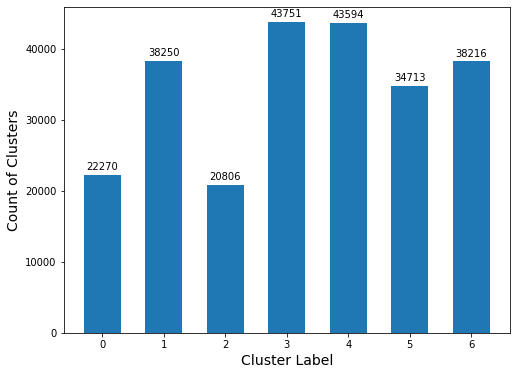

In [81]:
# With ICA and 7 clusters - Best model
kmeans_Model = KMeans(n_clusters=7, init='k-means++', n_init=10, max_iter=500
                          , precompute_distances=True, random_state=0)
kmeans_Model.fit(X_ICA)
predict_clusters = kmeans_Model.predict(X_ICA)
(unique, counts) = np.unique(predict_clusters, return_counts=True)
print(unique)
print(counts)

# Plotting the cluster counts
plt.rcParams['figure.figsize'] = (8, 6)
plt.bar(unique, counts, width=0.6, align='center')
plt.xlabel('Cluster Label', fontsize=14)
plt.ylabel('Count of Clusters', fontsize=14)
plt.xticks(unique)
for i, v in enumerate(counts):
    plt.text(i,v+1200,str(v), horizontalalignment='center', verticalalignment='center')
plt.show()

In [82]:
# Scores with class labels
print("adjusted_rand_score:", metrics.adjusted_rand_score(y, predict_clusters))
print("adjusted_mutual_info_score:", metrics.adjusted_mutual_info_score(y, predict_clusters))
print("homogeneity_score:", metrics.homogeneity_score(y, predict_clusters))
print("completeness_score:", metrics.completeness_score(y, predict_clusters))

adjusted_rand_score: 0.00993050910320587
adjusted_mutual_info_score: 0.019521331056157127
homogeneity_score: 0.03669656542730984
completeness_score: 0.013306279928234563


In [83]:
# Scores with clusters of K-means without dimentionality reduction
print("adjusted_rand_score:", metrics.adjusted_rand_score(predict_kmeans, predict_clusters))
print("adjusted_mutual_info_score:", metrics.adjusted_mutual_info_score(predict_kmeans, predict_clusters))
print("homogeneity_score:", metrics.homogeneity_score(predict_kmeans, predict_clusters))
print("completeness_score:", metrics.completeness_score(predict_kmeans, predict_clusters))

adjusted_rand_score: 0.39190387359538714
adjusted_mutual_info_score: 0.5420434977928799
homogeneity_score: 0.5505539822171802
completeness_score: 0.5338272748324677


#### With RP 

In [84]:
sse = []
ars = []
amis = []
hs = []
cs = []
cluster_size = np.arange(2,10,1)

for i in cluster_size:
    kmeans_Model = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=500
                          , precompute_distances=True, random_state=0)
    kmeans_Model.fit(X_RP)
    sse.append(kmeans_Model.inertia_)
    
    predict_clusters = kmeans_Model.predict(X_RP)
    ars.append(metrics.adjusted_rand_score(y, predict_clusters))
    amis.append(metrics.adjusted_mutual_info_score(y, predict_clusters))
    hs.append(metrics.homogeneity_score(y, predict_clusters))
    cs.append(metrics.completeness_score(y, predict_clusters))

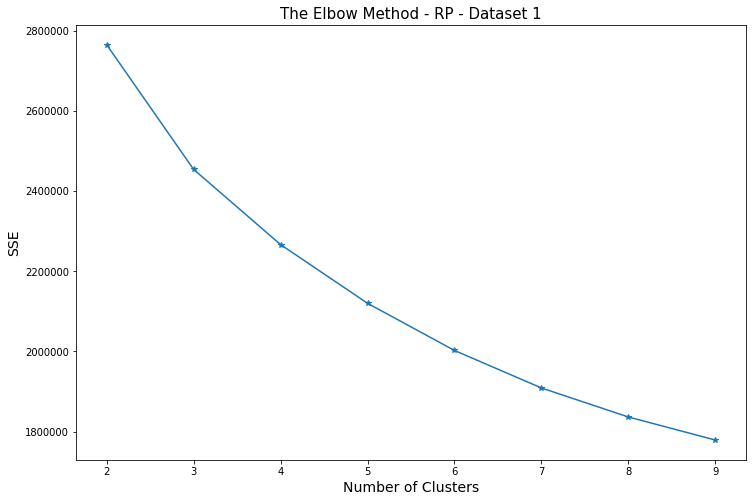

In [85]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.plot(cluster_size, sse, marker='*')
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('SSE', fontsize=14)
plt.xticks(cluster_size)
plt.title('The Elbow Method - RP - Dataset 1', fontsize=15)
plt.show()

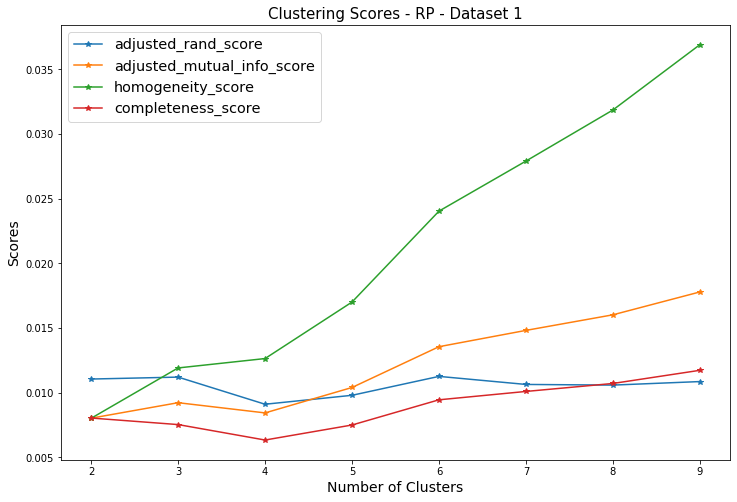

In [86]:
plt.plot(cluster_size, ars, marker='*', label='adjusted_rand_score')
plt.plot(cluster_size, amis, marker='*', label='adjusted_mutual_info_score')
plt.plot(cluster_size, hs, marker='*', label='homogeneity_score')
plt.plot(cluster_size, cs, marker='*', label='completeness_score')
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.xticks(cluster_size)
plt.legend(fontsize='x-large')
plt.title('Clustering Scores - RP - Dataset 1', fontsize=15)
plt.show()

[0 1 2 3 4 5 6]
[38759 24481 21541 40241 46054 34589 35935]


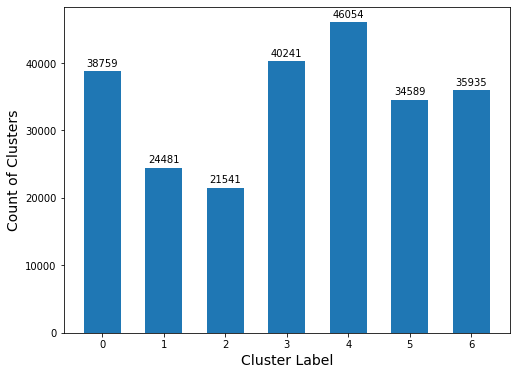

In [88]:
# With RP and 7 clusters - best model
kmeans_Model = KMeans(n_clusters=7, init='k-means++', n_init=10, max_iter=500
                          , precompute_distances=True, random_state=0)
kmeans_Model.fit(X_RP)
predict_clusters = kmeans_Model.predict(X_RP)
(unique, counts) = np.unique(predict_clusters, return_counts=True)
print(unique)
print(counts)

# Plotting the cluster counts
plt.rcParams['figure.figsize'] = (8, 6)
plt.bar(unique, counts, width=0.6, align='center')
plt.xlabel('Cluster Label', fontsize=14)
plt.ylabel('Count of Clusters', fontsize=14)
plt.xticks(unique)
for i, v in enumerate(counts):
    plt.text(i,v+1200,str(v), horizontalalignment='center', verticalalignment='center')
plt.show()

In [89]:
# Scores with class labels
print("adjusted_rand_score:", metrics.adjusted_rand_score(y, predict_clusters))
print("adjusted_mutual_info_score:", metrics.adjusted_mutual_info_score(y, predict_clusters))
print("homogeneity_score:", metrics.homogeneity_score(y, predict_clusters))
print("completeness_score:", metrics.completeness_score(y, predict_clusters))

adjusted_rand_score: 0.010628110297971156
adjusted_mutual_info_score: 0.014807295023525471
homogeneity_score: 0.027900116171944846
completeness_score: 0.01008664719106441


In [90]:
# Scores with clusters of K-means without dimentionality reduction
print("adjusted_rand_score:", metrics.adjusted_rand_score(predict_kmeans, predict_clusters))
print("adjusted_mutual_info_score:", metrics.adjusted_mutual_info_score(predict_kmeans, predict_clusters))
print("homogeneity_score:", metrics.homogeneity_score(predict_kmeans, predict_clusters))
print("completeness_score:", metrics.completeness_score(predict_kmeans, predict_clusters))

adjusted_rand_score: 0.2667175975037946
adjusted_mutual_info_score: 0.34474615107516393
homogeneity_score: 0.35070255791828103
completeness_score: 0.33903877228726037


#### With Feature Selection

In [91]:
sse = []
ars = []
amis = []
hs = []
cs = []
cluster_size = np.arange(2,10,1)

for i in cluster_size:
    kmeans_Model = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=500
                          , precompute_distances=True, random_state=0)
    kmeans_Model.fit(X_FS)
    sse.append(kmeans_Model.inertia_)
    
    predict_clusters = kmeans_Model.predict(X_FS)
    ars.append(metrics.adjusted_rand_score(y, predict_clusters))
    amis.append(metrics.adjusted_mutual_info_score(y, predict_clusters))
    hs.append(metrics.homogeneity_score(y, predict_clusters))
    cs.append(metrics.completeness_score(y, predict_clusters))

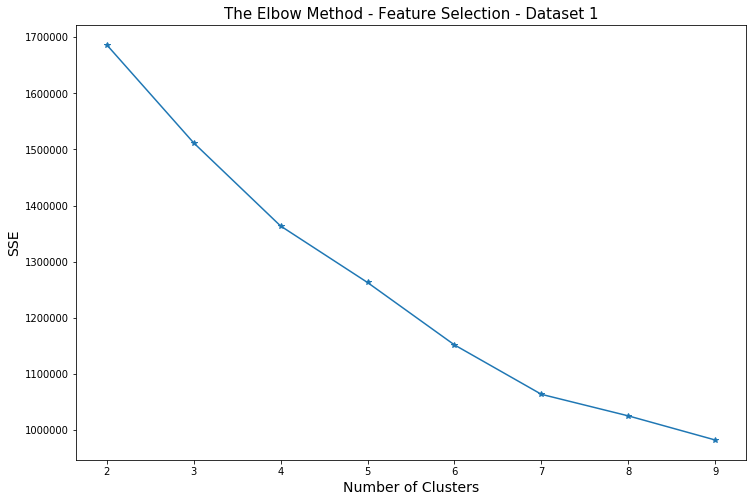

In [92]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.plot(cluster_size, sse, marker='*')
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('SSE', fontsize=14)
plt.xticks(cluster_size)
plt.title('The Elbow Method - Feature Selection - Dataset 1', fontsize=15)
plt.show()

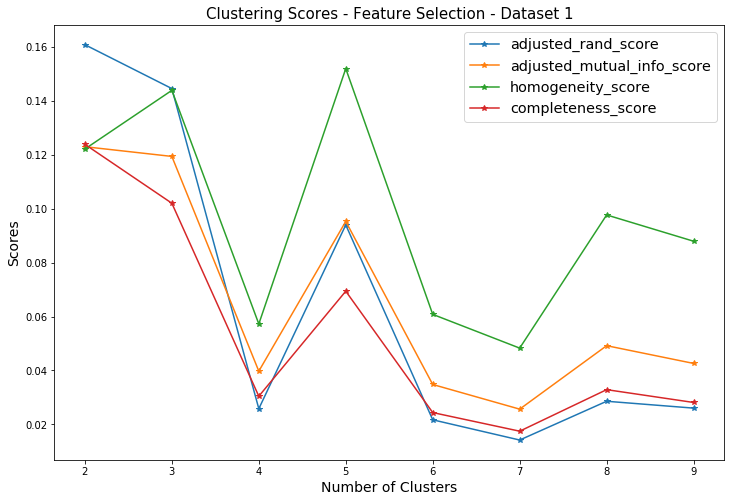

In [93]:
plt.plot(cluster_size, ars, marker='*', label='adjusted_rand_score')
plt.plot(cluster_size, amis, marker='*', label='adjusted_mutual_info_score')
plt.plot(cluster_size, hs, marker='*', label='homogeneity_score')
plt.plot(cluster_size, cs, marker='*', label='completeness_score')
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.xticks(cluster_size)
plt.legend(fontsize='x-large')
plt.title('Clustering Scores - Feature Selection - Dataset 1', fontsize=15)
plt.show()

[0 1 2 3 4 5 6]
[40928 28448 40928 30496 40928 18944 40928]


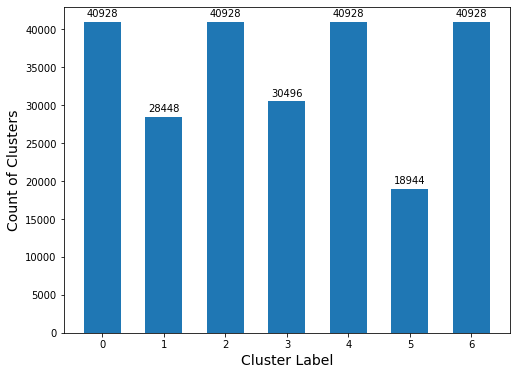

In [95]:
# With Feature Selection and 7 clusters - best model
kmeans_Model = KMeans(n_clusters=7, init='k-means++', n_init=10, max_iter=500
                          , precompute_distances=True, random_state=0)
kmeans_Model.fit(X_FS)
predict_clusters = kmeans_Model.predict(X_FS)
(unique, counts) = np.unique(predict_clusters, return_counts=True)
print(unique)
print(counts)

# Plotting the cluster counts
plt.rcParams['figure.figsize'] = (8,6)
plt.bar(unique, counts, width=0.6, align='center')
plt.xlabel('Cluster Label', fontsize=14)
plt.ylabel('Count of Clusters', fontsize=14)
plt.xticks(unique)
for i, v in enumerate(counts):
    plt.text(i,v+1100,str(v), horizontalalignment='center', verticalalignment='center')
plt.show()

In [96]:
# Scores with class labels
print("adjusted_rand_score:", metrics.adjusted_rand_score(y, predict_clusters))
print("adjusted_mutual_info_score:", metrics.adjusted_mutual_info_score(y, predict_clusters))
print("homogeneity_score:", metrics.homogeneity_score(y, predict_clusters))
print("completeness_score:", metrics.completeness_score(y, predict_clusters))

adjusted_rand_score: 0.01419463198451519
adjusted_mutual_info_score: 0.025653492060247106
homogeneity_score: 0.04829694314994657
completeness_score: 0.01747375765357849


In [97]:
# Scores with clusters of K-means without dimentionality reduction
print("adjusted_rand_score:", metrics.adjusted_rand_score(predict_kmeans, predict_clusters))
print("adjusted_mutual_info_score:", metrics.adjusted_mutual_info_score(predict_kmeans, predict_clusters))
print("homogeneity_score:", metrics.homogeneity_score(predict_kmeans, predict_clusters))
print("completeness_score:", metrics.completeness_score(predict_kmeans, predict_clusters))

adjusted_rand_score: 0.3049610197383464
adjusted_mutual_info_score: 0.4936716864932405
homogeneity_score: 0.5019923160399772
completeness_score: 0.4856611323565356


### ANN after Dimensionality Reduction

#### Original ANN

In [59]:
#Splitting into train-test datasets
X = df.drop(["Tgt_Class"], axis=1)
y = df["Tgt_Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 11)

#Scaling the independent features
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [60]:
ANN_model = MLPClassifier(hidden_layer_sizes=(40,40,40), solver='adam', alpha=0.00001, activation='relu'
                          , max_iter=200, random_state=0)
ANN_model.fit(X_train, y_train)
y_pred_ANN_test = ANN_model.predict(X_test)

In [61]:
print("Accuracy:", accuracy_score(y_test,y_pred_ANN_test))

Accuracy: 0.9872792494481236


#### With PCA

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_PCA, y, test_size = 0.30, random_state = 11)

In [63]:
ANN_model = MLPClassifier(hidden_layer_sizes=(40,40,40), solver='adam', alpha=0.00001, activation='relu'
                          , max_iter=200, random_state=0)
ANN_model.fit(X_train, y_train)
y_pred_ANN_test = ANN_model.predict(X_test)

In [64]:
print("Accuracy:", accuracy_score(y_test,y_pred_ANN_test))

Accuracy: 0.9662941501103752


#### With ICA

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_ICA, y, test_size = 0.30, random_state = 11)

In [66]:
ANN_model = MLPClassifier(hidden_layer_sizes=(40,40,40), solver='adam', alpha=0.00001, activation='relu'
                          , max_iter=200, random_state=0)
ANN_model.fit(X_train, y_train)
y_pred_ANN_test = ANN_model.predict(X_test)

In [67]:
print("Accuracy:", accuracy_score(y_test,y_pred_ANN_test))

Accuracy: 0.8382174392935983


#### With RP

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X_RP, y, test_size = 0.30, random_state = 11)

In [69]:
ANN_model = MLPClassifier(hidden_layer_sizes=(40,40,40), solver='adam', alpha=0.00001, activation='relu'
                          , max_iter=200, random_state=0)
ANN_model.fit(X_train, y_train)
y_pred_ANN_test = ANN_model.predict(X_test)

In [70]:
print("Accuracy:", accuracy_score(y_test,y_pred_ANN_test))

Accuracy: 0.8246412803532008


#### With Feature Selection

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_FS, y, test_size = 0.30, random_state = 11)

In [72]:
ANN_model = MLPClassifier(hidden_layer_sizes=(40,40,40), solver='adam', alpha=0.00001, activation='relu'
                          , max_iter=200, random_state=0)
ANN_model.fit(X_train, y_train)
y_pred_ANN_test = ANN_model.predict(X_test)

In [73]:
print("Accuracy:", accuracy_score(y_test,y_pred_ANN_test))

Accuracy: 0.9528559602649007


#### Plotting accuracies for ANN

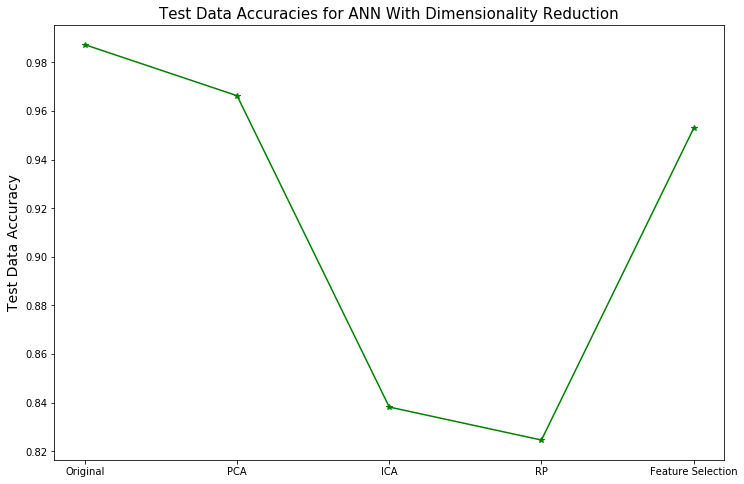

In [75]:
plt.rcParams['figure.figsize'] = (12, 8)
accuracy = [0.9872792494481236, 0.9662941501103752, 0.8382174392935983, 0.8246412803532008, 0.9528559602649007]
x_labels = ['Original', 'PCA', 'ICA', 'RP', 'Feature Selection']
plt.plot(x_labels, accuracy, marker='*', color='green')
plt.ylabel('Test Data Accuracy', fontsize=14)
plt.title('Test Data Accuracies for ANN With Dimensionality Reduction', fontsize=15)
plt.show()

### Expectation Maximization

#### Without Dimensionality Reduction

In [11]:
bic = []
cv_types = ['spherical', 'tied', 'diag', 'full']
n_components = np.arange(1,10,1)
for i in cv_types:
    bic_cv = []
    for n in n_components:
        EM_Model = GaussianMixture(n_components=n, covariance_type=i,n_init=1)
        EM_Model.fit(X_sc)
        bic_cv.append(EM_Model.bic(X_sc))
    bic.append(bic_cv)

Minimum BIC for Covariance Type spherical : 9241220.06499 at Components: 9
Minimum BIC for Covariance Type tied : 8821067.76260 at Components: 9
Minimum BIC for Covariance Type diag : 4763408.06246 at Components: 8
Minimum BIC for Covariance Type full : 5408235.91187 at Components: 9




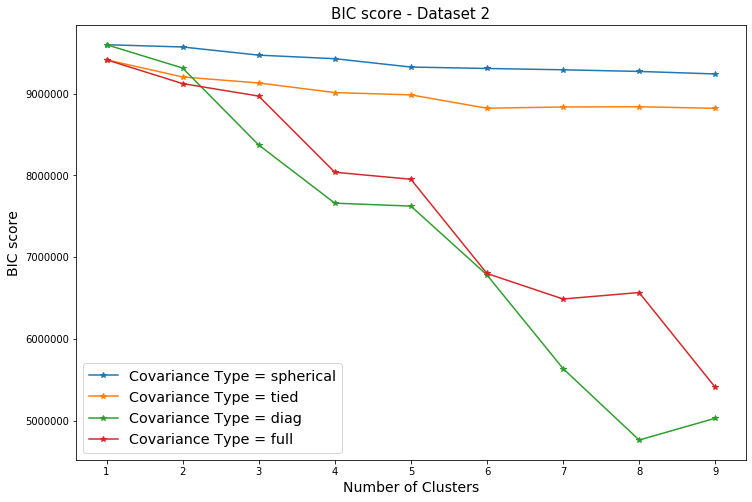

In [13]:
plt.rcParams['figure.figsize'] = (12, 8)
for i in range(0,4):
    print("Minimum BIC for Covariance Type", cv_types[i] ,":", "{:.5f}".format(min(bic[i]))
          , "at Components:", n_components[bic[i].index(min(bic[i]))])
print("\n")

for i in range(0,len(cv_types)):
    plt.plot(n_components, bic[i], marker='*', label="Covariance Type = {}".format(cv_types[i]))
    plt.legend(fontsize='x-large')
    plt.xlabel('Number of Clusters', fontsize=14)
    plt.ylabel('BIC score', fontsize=14)
    plt.title('BIC score - Dataset 1', fontsize=15)

In [19]:
# best model
EM_Model = GaussianMixture(n_components=8, covariance_type='diag', n_init=2)
EM_Model.fit(X_sc)
predict_clusters_EM_original = EM_Model.predict(X_sc)

In [20]:
# Scores with class labels
print("adjusted_rand_score:", metrics.adjusted_rand_score(y, predict_clusters_EM_original))
print("adjusted_mutual_info_score:", metrics.adjusted_mutual_info_score(y, predict_clusters_EM_original))
print("homogeneity_score:", metrics.homogeneity_score(y, predict_clusters_EM_original))
print("completeness_score:", metrics.completeness_score(y, predict_clusters_EM_original))

adjusted_rand_score: 0.025692574278455463
adjusted_mutual_info_score: 0.040736199301944484
homogeneity_score: 0.0803830658216929
completeness_score: 0.027289816736256158


#### With PCA

In [22]:
bic = []
cv_types = ['spherical', 'tied', 'diag', 'full']
n_components = np.arange(1,10,1)
for i in cv_types:
    bic_cv = []
    for n in n_components:
        EM_Model = GaussianMixture(n_components=n, covariance_type=i, n_init=1)
        EM_Model.fit(X_PCA)
        bic_cv.append(EM_Model.bic(X_PCA))
    bic.append(bic_cv)

Minimum BIC for Covariance Type spherical : 7061772.34417 at Components: 9
Minimum BIC for Covariance Type tied : 3843305.05793 at Components: 9
Minimum BIC for Covariance Type diag : 6895833.40947 at Components: 8
Minimum BIC for Covariance Type full : 1861752.86804 at Components: 8




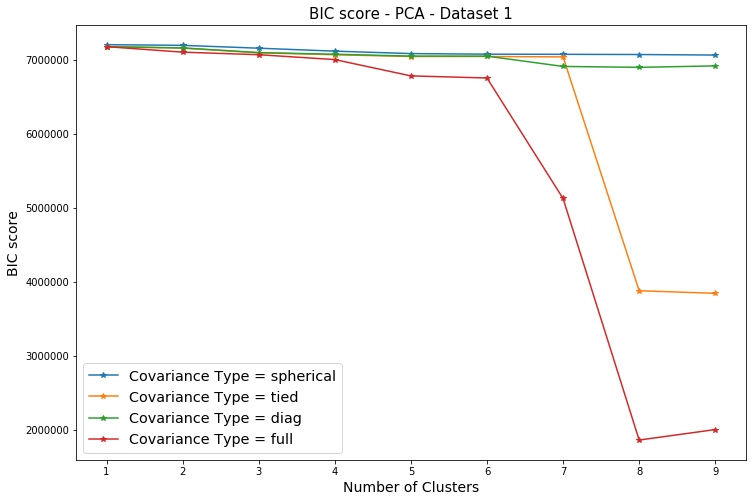

In [23]:
for i in range(0,4):
    print("Minimum BIC for Covariance Type", cv_types[i] ,":", "{:.5f}".format(min(bic[i]))
          , "at Components:", n_components[bic[i].index(min(bic[i]))])
print("\n")

for i in range(0,len(cv_types)):
    plt.plot(n_components, bic[i], marker='*', label="Covariance Type = {}".format(cv_types[i]))
    plt.legend(fontsize='x-large')
    plt.xlabel('Number of Clusters', fontsize=14)
    plt.ylabel('BIC score', fontsize=14)
    plt.title('BIC score - PCA - Dataset 1', fontsize=15)

In [24]:
# best model
EM_Model = GaussianMixture(n_components=8, covariance_type='full', n_init=2)
EM_Model.fit(X_PCA)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=2, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [25]:
EM_Model.bic(X_PCA)

2093095.5248263048

In [26]:
predict_clusters = EM_Model.predict(X_PCA)

In [27]:
# Scores with class labels
print("adjusted_rand_score:", metrics.adjusted_rand_score(y, predict_clusters))
print("adjusted_mutual_info_score:", metrics.adjusted_mutual_info_score(y, predict_clusters))
print("homogeneity_score:", metrics.homogeneity_score(y, predict_clusters))
print("completeness_score:", metrics.completeness_score(y, predict_clusters))

adjusted_rand_score: 0.009534273134123751
adjusted_mutual_info_score: 0.020997829356619736
homogeneity_score: 0.03514452653423879
completeness_score: 0.014983843336783901


In [28]:
# Scores with EM model without dimensionality reduction
print("adjusted_rand_score:", metrics.adjusted_rand_score(predict_clusters_EM_original, predict_clusters))
print("adjusted_mutual_info_score:", metrics.adjusted_mutual_info_score(predict_clusters_EM_original, predict_clusters))
print("homogeneity_score:", metrics.homogeneity_score(predict_clusters_EM_original, predict_clusters))
print("completeness_score:", metrics.completeness_score(predict_clusters_EM_original, predict_clusters))

adjusted_rand_score: 0.09044381504886023
adjusted_mutual_info_score: 0.2431708000517989
homogeneity_score: 0.21844007086618375
completeness_score: 0.27432272267392843


#### With ICA

In [29]:
bic = []
cv_types = ['spherical', 'tied', 'diag', 'full']
n_components = np.arange(1,10,1)
for i in cv_types:
    bic_cv = []
    for n in n_components:
        EM_Model = GaussianMixture(n_components=n, covariance_type=i,n_init=1)
        EM_Model.fit(X_ICA)
        bic_cv.append(EM_Model.bic(X_ICA))
    bic.append(bic_cv)

Minimum BIC for Covariance Type spherical : -23062158.39649 at Components: 8
Minimum BIC for Covariance Type tied : -23291614.46901 at Components: 4
Minimum BIC for Covariance Type diag : -23548076.53997 at Components: 9
Minimum BIC for Covariance Type full : -23750083.22123 at Components: 9




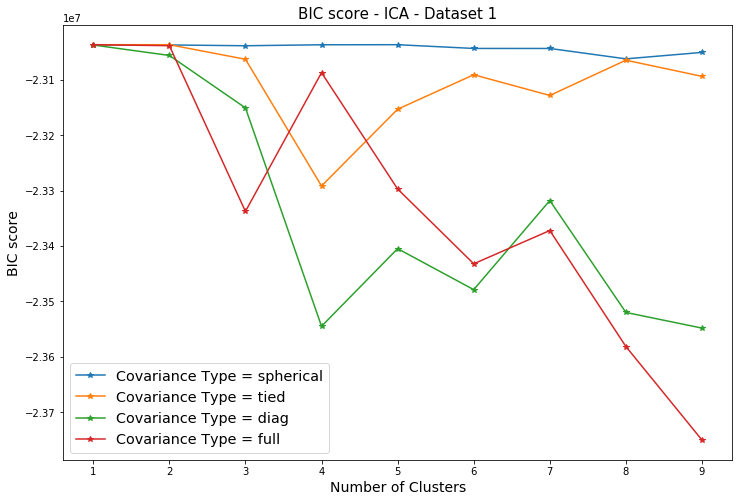

In [30]:
for i in range(0,4):
    print("Minimum BIC for Covariance Type", cv_types[i] ,":", "{:.5f}".format(min(bic[i]))
          , "at Components:", n_components[bic[i].index(min(bic[i]))])
print("\n")

for i in range(0,len(cv_types)):
    plt.plot(n_components, bic[i], marker='*', label="Covariance Type = {}".format(cv_types[i]))
    plt.legend(fontsize='x-large')
    plt.xlabel('Number of Clusters', fontsize=14)
    plt.ylabel('BIC score', fontsize=14)
    plt.title('BIC score - ICA - Dataset 1', fontsize=15)

In [31]:
# best model
EM_Model = GaussianMixture(n_components=9, covariance_type='full', n_init=2)
EM_Model.fit(X_ICA)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=9, n_init=2, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [32]:
EM_Model.bic(X_ICA)

-23537200.930804115

In [33]:
predict_clusters = EM_Model.predict(X_ICA)

In [34]:
# Scores with class labels
print("adjusted_rand_score:", metrics.adjusted_rand_score(y, predict_clusters))
print("adjusted_mutual_info_score:", metrics.adjusted_mutual_info_score(y, predict_clusters))
print("homogeneity_score:", metrics.homogeneity_score(y, predict_clusters))
print("completeness_score:", metrics.completeness_score(y, predict_clusters))

adjusted_rand_score: 0.008554652719481814
adjusted_mutual_info_score: 0.010834359938743108
homogeneity_score: 0.018216940299277444
completeness_score: 0.007720555806930491


In [35]:
# Scores with EM model without dimensionality reduction
print("adjusted_rand_score:", metrics.adjusted_rand_score(predict_clusters_EM_original, predict_clusters))
print("adjusted_mutual_info_score:", metrics.adjusted_mutual_info_score(predict_clusters_EM_original, predict_clusters))
print("homogeneity_score:", metrics.homogeneity_score(predict_clusters_EM_original, predict_clusters))
print("completeness_score:", metrics.completeness_score(predict_clusters_EM_original, predict_clusters))

adjusted_rand_score: 0.01668377530456704
adjusted_mutual_info_score: 0.0644979220115823
homogeneity_score: 0.058122024171242195
completeness_score: 0.07255674798191014


#### With RP

In [36]:
bic = []
cv_types = ['spherical', 'tied', 'diag', 'full']
n_components = np.arange(1,10,1)
for i in cv_types:
    bic_cv = []
    for n in n_components:
        EM_Model = GaussianMixture(n_components=n, covariance_type=i, n_init=1)
        EM_Model.fit(X_RP)
        bic_cv.append(EM_Model.bic(X_RP))
    bic.append(bic_cv)

Minimum BIC for Covariance Type spherical : 7034483.87131 at Components: 9
Minimum BIC for Covariance Type tied : 5830151.97865 at Components: 9
Minimum BIC for Covariance Type diag : 6228876.94144 at Components: 9
Minimum BIC for Covariance Type full : 5308369.52961 at Components: 8




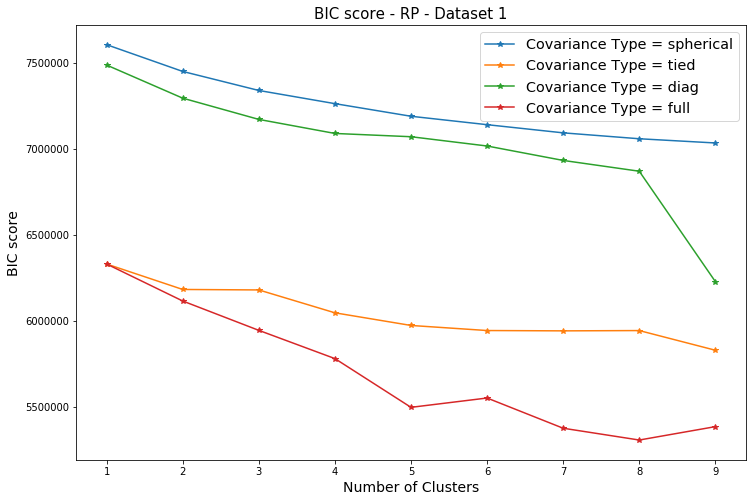

In [37]:
for i in range(0,4):
    print("Minimum BIC for Covariance Type", cv_types[i] ,":", "{:.5f}".format(min(bic[i]))
          , "at Components:", n_components[bic[i].index(min(bic[i]))])
print("\n")

for i in range(0,len(cv_types)):
    plt.plot(n_components, bic[i], marker='*', label="Covariance Type = {}".format(cv_types[i]))
    plt.legend(fontsize='x-large')
    plt.xlabel('Number of Clusters', fontsize=14)
    plt.ylabel('BIC score', fontsize=14)
    plt.title('BIC score - RP - Dataset 1', fontsize=15)

In [38]:
EM_Model = GaussianMixture(n_components=8, covariance_type='full', n_init=2)
EM_Model.fit(X_RP)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=2, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [39]:
EM_Model.bic(X_RP)

5402378.874160031

In [40]:
predict_clusters = EM_Model.predict(X_RP)

In [41]:
# Scores with class labels
print("adjusted_rand_score:", metrics.adjusted_rand_score(y, predict_clusters))
print("adjusted_mutual_info_score:", metrics.adjusted_mutual_info_score(y, predict_clusters))
print("homogeneity_score:", metrics.homogeneity_score(y, predict_clusters))
print("completeness_score:", metrics.completeness_score(y, predict_clusters))

adjusted_rand_score: 0.00649594476715825
adjusted_mutual_info_score: 0.013895136232199113
homogeneity_score: 0.026990082272491833
completeness_score: 0.009365514571761185


In [42]:
# Scores with EM model without dimensionality reduction
print("adjusted_rand_score:", metrics.adjusted_rand_score(predict_clusters_EM_original, predict_clusters))
print("adjusted_mutual_info_score:", metrics.adjusted_mutual_info_score(predict_clusters_EM_original, predict_clusters))
print("homogeneity_score:", metrics.homogeneity_score(predict_clusters_EM_original, predict_clusters))
print("completeness_score:", metrics.completeness_score(predict_clusters_EM_original, predict_clusters))

adjusted_rand_score: 0.4542433306965817
adjusted_mutual_info_score: 0.6093734562794578
homogeneity_score: 0.6028062538880826
completeness_score: 0.6161254265948031


#### With Feature Selection

In [43]:
bic = []
cv_types = ['spherical', 'tied', 'diag', 'full']
n_components = np.arange(1,10,1)
for i in cv_types:
    bic_cv = []
    for n in n_components:
        EM_Model = GaussianMixture(n_components=n, covariance_type=i, n_init=1)
        EM_Model.fit(X_FS)
        bic_cv.append(EM_Model.bic(X_FS))
    bic.append(bic_cv)

Minimum BIC for Covariance Type spherical : 5170856.21132 at Components: 9
Minimum BIC for Covariance Type tied : 4881893.71499 at Components: 9
Minimum BIC for Covariance Type diag : -2468656.53177 at Components: 9
Minimum BIC for Covariance Type full : -1371482.63041 at Components: 9




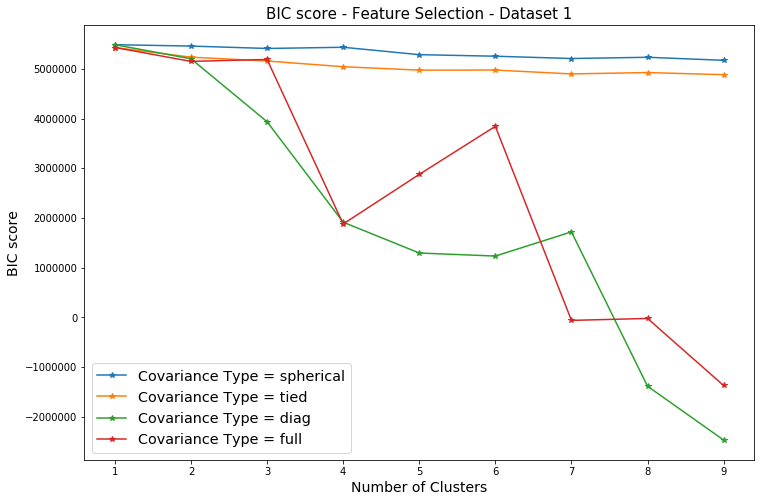

In [44]:
for i in range(0,4):
    print("Minimum BIC for Covariance Type", cv_types[i] ,":", "{:.5f}".format(min(bic[i]))
          , "at Components:", n_components[bic[i].index(min(bic[i]))])
print("\n")

for i in range(0,len(cv_types)):
    plt.plot(n_components, bic[i], marker='*', label="Covariance Type = {}".format(cv_types[i]))
    plt.legend(fontsize='x-large')
    plt.xlabel('Number of Clusters', fontsize=14)
    plt.ylabel('BIC score', fontsize=14)
    plt.title('BIC score - Feature Selection - Dataset 1', fontsize=15)

In [45]:
EM_Model = GaussianMixture(n_components=9, covariance_type='diag', n_init=2)
EM_Model.fit(X_FS)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=9, n_init=2, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [46]:
EM_Model.bic(X_FS)

-1923193.4565106924

In [47]:
predict_clusters = EM_Model.predict(X_FS)

In [48]:
# Scores with class labels
print("adjusted_rand_score:", metrics.adjusted_rand_score(y, predict_clusters))
print("adjusted_mutual_info_score:", metrics.adjusted_mutual_info_score(y, predict_clusters))
print("homogeneity_score:", metrics.homogeneity_score(y, predict_clusters))
print("completeness_score:", metrics.completeness_score(y, predict_clusters))

adjusted_rand_score: 0.008018621777724378
adjusted_mutual_info_score: 0.028780448932557996
homogeneity_score: 0.05291290151547066
completeness_score: 0.01977763291509124


In [49]:
# Scores with EM model without dimensionality reduction
print("adjusted_rand_score:", metrics.adjusted_rand_score(predict_clusters_EM_original, predict_clusters))
print("adjusted_mutual_info_score:", metrics.adjusted_mutual_info_score(predict_clusters_EM_original, predict_clusters))
print("homogeneity_score:", metrics.homogeneity_score(predict_clusters_EM_original, predict_clusters))
print("completeness_score:", metrics.completeness_score(predict_clusters_EM_original, predict_clusters))

adjusted_rand_score: 0.030638232606104078
adjusted_mutual_info_score: 0.10604049870579925
homogeneity_score: 0.1012286321815286
completeness_score: 0.111449994273006


### ANN with clustering results as features

In [100]:
kmeans_Model = KMeans(n_clusters=7, init='k-means++', n_init=10, max_iter=500, precompute_distances=True, random_state=0)
kmeans_Model.fit(X_sc)
X_kmeans = kmeans_Model.predict(X_sc)

In [101]:
X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X_kmeans, y, test_size=0.3, random_state=11)

In [102]:
ANN_model = MLPClassifier(hidden_layer_sizes=(40,40,40), solver='adam', alpha=0.00001, activation='relu'
                          , max_iter=200, random_state=0)
ANN_model.fit(X_train_k.reshape(-1,1), y_train_k)
y_pred_ANN_test = ANN_model.predict(X_test_k.reshape(-1,1))

In [103]:
print("Accuracy:", accuracy_score(y_test_k, y_pred_ANN_test))

Accuracy: 0.583567880794702
